## Parsing unity VR log file
...

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd

In [2]:
datapath = "sample/test_imaging/f02/Log_2020-8-31_19-15-6_4.json"

In [3]:
# Opening JSON file 
f = open(datapath,) 
  
# returns JSON object as  
# a dictionary 
data = json.load(f) 

#lines in document
lines = sum(1 for line in data)

In [4]:
for i in range(2):
    print(data[i]['frame'])
    print(json.dumps(data[i]['data'], sort_keys=True, indent=4))
    print('\n')

1.0
{
    "colliderType": "MeshCollider",
    "meshGameObjectPath": "Fly/FlyCamera3/FlyCamera3Screen",
    "worldPosition": {
        "x": 38.428314208984375,
        "y": 30.339401245117188,
        "z": -52.89203643798828
    },
    "worldRotationDegs": {
        "x": 0.0,
        "y": 324.0,
        "z": 0.0
    },
    "worldScale": {
        "x": 95.00000762939453,
        "y": 182.0,
        "z": 1.0
    }
}


1.0
{
    "colliderType": "MeshCollider",
    "meshGameObjectPath": "Fly/FlyCamera1/FlyCamera1Screen",
    "worldPosition": {
        "x": 0.0,
        "y": 30.339401245117188,
        "z": 65.37814331054688
    },
    "worldRotationDegs": {
        "x": 0.0,
        "y": 180.0,
        "z": 0.0
    },
    "worldScale": {
        "x": 95.0,
        "y": 182.0,
        "z": 1.0
    }
}




### Pull out object positions

In [5]:
objDfCols = ['name','collider','px','py','pz','rx','ry','rz','sx','sy','sz']

In [6]:
objDf = pd.DataFrame(columns=objDfCols)
for l in range(lines):
    dat = data[l]['data']
    if('meshGameObjectPath' in dat.keys()):
        framedat = {'name': dat['meshGameObjectPath'], 
                    'collider': dat['colliderType'], 
                    'px': dat['worldPosition']['x'], 
                    'py': dat['worldPosition']['z'],
                    'pz': dat['worldPosition']['y'],
                    'rx': dat['worldRotationDegs']['x'], 
                    'ry': dat['worldRotationDegs']['z'],
                    'rz': dat['worldRotationDegs']['y'],
                    'sx': dat['worldScale']['x'], 
                    'sy': dat['worldScale']['z'],
                    'sz': dat['worldScale']['y']}
        objDf = objDf.append(framedat, ignore_index = True)

In [7]:
objDf

,name,collider,px,py,pz,rx,ry,rz,sx,sy,sz
0,Fly/FlyCamera3/FlyCamera3Screen,MeshCollider,38.428314,-52.892036,30.339401,0.0,0.0,324.000000,95.000008,1.0,182.0
1,Fly/FlyCamera1/FlyCamera1Screen,MeshCollider,0.000000,65.378143,30.339401,0.0,0.0,180.000000,95.000000,1.0,182.0
2,Fly/FlyCamera2/FlyCamera2Screen,MeshCollider,62.178310,20.202957,30.339401,0.0,0.0,252.000000,95.000008,1.0,182.0
3,LMlocal1,CapsuleCollider,0.000000,-100.000000,27.000000,0.0,0.0,0.000000,10.000000,10.0,30.0
4,LMlocal2,CapsuleCollider,-150.000000,100.000000,27.000000,0.0,0.0,0.000000,10.000000,10.0,30.0
5,Fly/FlyCamera4/FlyCamera4Screen,MeshCollider,-38.428303,-52.892036,30.339401,0.0,0.0,35.999996,95.000000,1.0,182.0


### Pull out fly position
#### Position in VR

In [8]:
posDfCols = ['frame','time','x','y','angle']

In [9]:
posDf = pd.DataFrame(columns=posDfCols)
for l in range(lines):
    dat = data[l]['data']
    if( 'worldPosition' in dat.keys() and not 'meshGameObjectPath' in dat.keys() ):
        framedat = {'frame': data[l]['frame'], 
                    'time': data[l]['timeSecs'], 
                    'x': dat['worldPosition']['x'], 
                    'y': dat['worldPosition']['z'],
                    'angle': dat['worldRotationDegs']['y']}
        posDf = posDf.append(framedat, ignore_index = True)
    

In [10]:
posDf.head()

,frame,time,x,y,angle
0,1.0,0.000000,0.029138,-0.109734,359.992584
1,2.0,0.020000,-0.063957,-0.316354,0.053297
2,3.0,0.026142,-0.068326,-0.301990,0.091445
3,4.0,0.031466,0.317903,-0.263294,0.064798
4,5.0,0.034920,0.761612,-0.212639,359.769287


#### Position based on Fictrac tracking

In [11]:
ftDfCols = ['frame','ficTracTReadMs','ficTracTWriteMs','dx','dy','dz']

ftDf = pd.DataFrame(columns=ftDfCols)
for l in range(lines):
    dat = data[l]['data']
    if( 'ficTracDeltaRotationVectorLab' in dat.keys() ):
        framedat = {'frame': data[l]['frame'], 
                    'ficTracTReadMs': dat['ficTracTimestampReadMs'], 
                    'ficTracTWriteMs': dat['ficTracTimestampWriteMs'], 
                    'dx': dat['ficTracDeltaRotationVectorLab']['x'], 
                    'dy': dat['ficTracDeltaRotationVectorLab']['y'],
                    'dz': dat['ficTracDeltaRotationVectorLab']['z']}
        ftDf = ftDf.append(framedat, ignore_index = True)

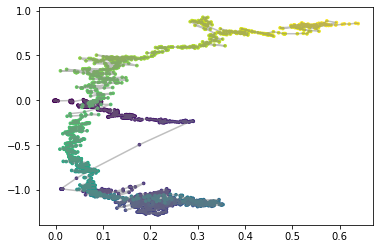

In [15]:
ballr = 45
#plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
#plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['time'],cmap='viridis')

# See Seelig 2010 for reference on equations (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2945246/)
fta = np.cumsum(ftDf['dz'])
fty = np.cumsum(ballr*np.pi/180*ftDf['dy']*np.cos(fta) - ballr*np.pi/180*ftDf['dx']*np.sin(fta))
ftx = np.cumsum(ballr*np.pi/180*ftDf['dy']*np.sin(fta) + ballr*np.pi/180*ftDf['dx']*np.cos(fta))
plt.plot(ftx[0:3000], fty[0:3000],color='grey',alpha=0.5)
plt.scatter(ftx[0:3000], fty[0:3000],s=7,c=ftDf['frame'][0:3000],cmap='viridis')

### Vizualize trajectory and object positions

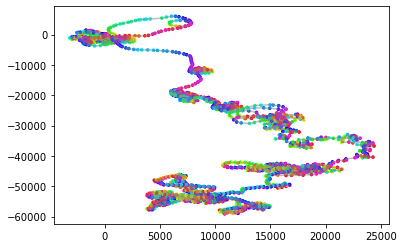

In [16]:
plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['angle'],cmap='hsv')

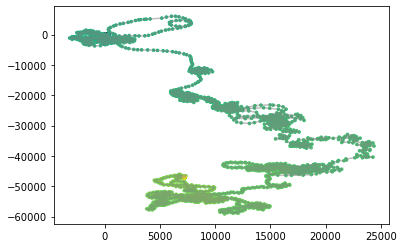

In [17]:
plt.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
plt.scatter(posDf['x'], posDf['y'],s=7,c=posDf['time'],cmap='viridis')

LMlocal1
LMlocal2


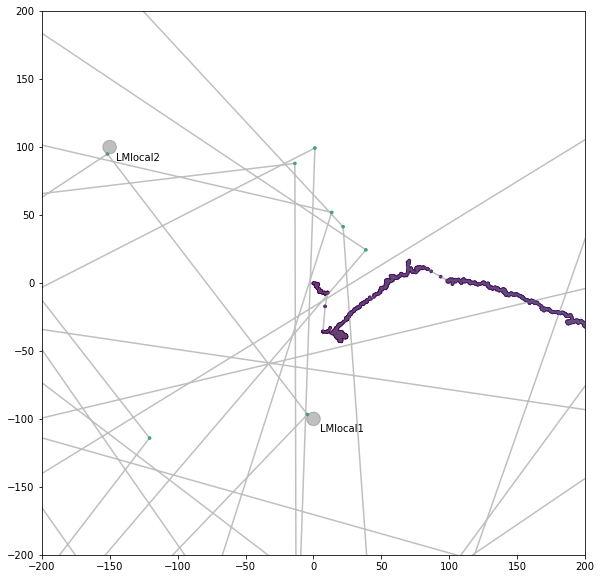

In [18]:
import matplotlib.patches as mpatches
from matplotlib import patches

minv = -200
maxv = 200

fig, ax = plt.subplots(1,1, figsize=(10,10))
for obj in range(objDf.shape[0]):
    if("FlyCamera" not in objDf.name[obj]):
        print(objDf['name'][obj])
        #ax.plot(objDf['px'][obj], objDf['py'][obj],marker='o')
        ellipse = mpatches.Ellipse((objDf['px'][obj], objDf['py'][obj]), objDf['sx'][obj], objDf['sy'][obj], color='grey', alpha=0.5)
        ax.add_patch(ellipse)
        ax.annotate(objDf['name'][obj], (objDf['px'][obj]+5, objDf['py'][obj]-10))

ax.plot(posDf['x'], posDf['y'],color='grey',alpha=0.5)
ax.scatter(posDf['x'], posDf['y'],s=7,c=posDf['time'],cmap='viridis')
ax.set_ylim(minv, maxv)
ax.set_xlim(minv, maxv)
ax.set_aspect('equal')

In [294]:
# Closing file 
f.close() 